In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import math
import seaborn as sns
import numpy as np
import requests
import time
from datetime import datetime
import sys
from io import StringIO
sns.set()

In [5]:
ts = int(time.time())
sp_data_resp = requests.get('https://query1.finance.yahoo.com/v7/finance/download/^GSPC?'\
    'period1=-1325635200&period2={}&interval=1d&events=history'\
    .format(ts))

In [8]:
sp_data = pd.read_csv(StringIO(sp_data_resp.text))
sp_data['Date'] = pd.to_datetime(sp_data['Date'])

In [10]:
date_string = datetime.today().strftime('%Y-%m-%d')
cpi_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?'\
          'bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&'\
          'graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&'\
          'txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&'\
          'show_axis_titles=yes&show_tooltip=yes&id=CPIAUCNS&scale=left&cosd=1913-01-01&'\
          'coed=2020-08-01&line_color=%234572a7&link_values=false&line_style=solid&'\
          'mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&'\
          'fam=avg&fgst=lin&fgsnd={}&line_index=1&transformation=lin&'\
          'vintage_date={}&revision_date={}&nd=1913-01-01'.format(date_string, date_string,date_string)

inf_data_resp = requests.get(cpi_url)

In [11]:
inf_data = pd.read_csv(StringIO(inf_data_resp.text))
inf_data['DATE'] = pd.to_datetime(inf_data['DATE'])

# S&P 500

In [15]:
close = sp_data.set_index('Date')['Close']
years = (close.index[-1] - close.index[0])/np.timedelta64(1, 'Y')
md('Data start: {}  \n Data end: {}  \n Years: {:.2f}'.format(sp_data['Date'].min(),sp_data['Date'].max(),years))

Data start: 1927-12-30 00:00:00  
 Data end: 2020-10-02 00:00:00  
 Years: 92.76

## Historical Prices

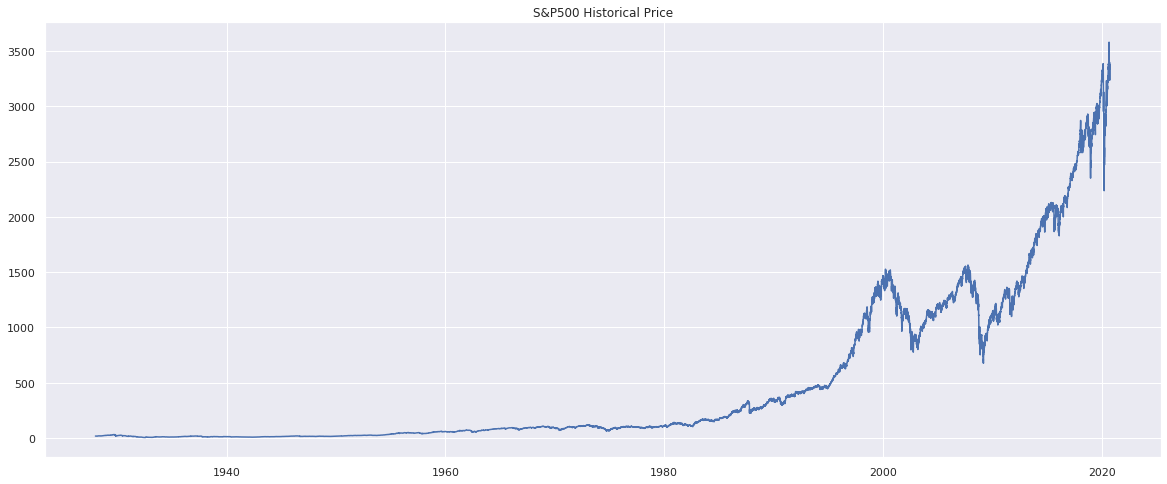

In [16]:
plt.figure(figsize=(20,8))
plt.title('S&P500 Historical Price')
plt.plot(close);

In [17]:
total_growth = close.iloc[-1]/close.iloc[0]
rate = ((close.iloc[-1]/close.iloc[0])**(1/years)-1)*100
years_to_double = math.log(2)/math.log(1 + rate/100)
md('Total growth: {:.2f} times original value  \n' \
   'Yearly growth rate: {:.2f}%  \n' \
   'Doubles every: {:.2f} years  \n'.format(total_growth, rate, years_to_double))

Total growth: 189.60 times original value  
Yearly growth rate: 5.82%  
Doubles every: 12.26 years  


## Historical Prices (log scale)

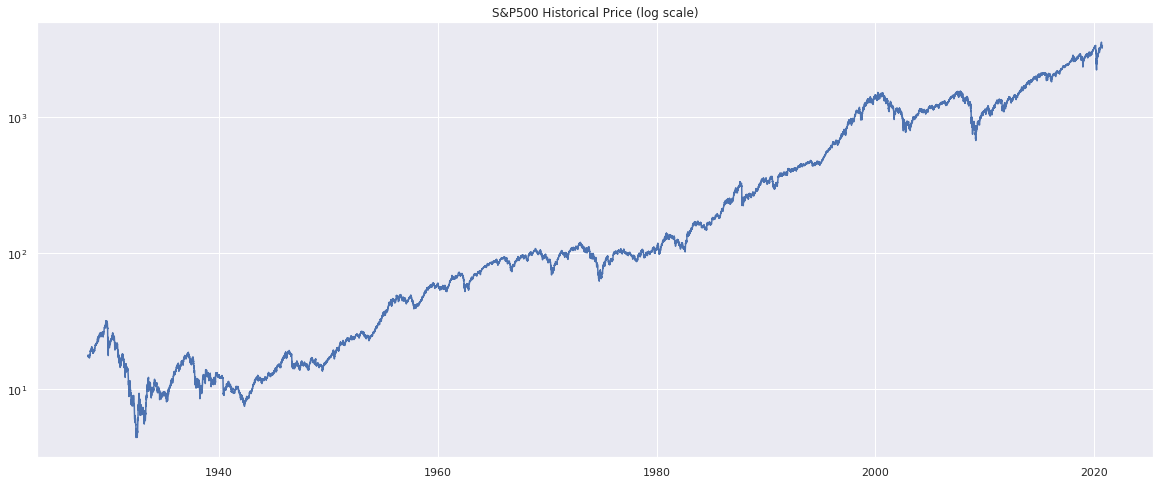

In [18]:
plt.figure(figsize=(20,8))
plt.title('S&P500 Historical Price (log scale)')
plt.yscale("log")
plt.plot(close);

# Historical Inflation

In [ ]:
sp_data['month_start'] = sp_data['Date'] - pd.offsets.MonthBegin(1)
sp_data = sp_data.merge(inf_data, left_on='month_start', right_on='DATE')
sp_data['inf_adj_close'] = (sp_data['Close']/sp_data['CPIAUCNS'])*inf_data['CPIAUCNS'].iloc[-1]
inf_adj_close = sp_data.set_index('Date')['inf_adj_close']

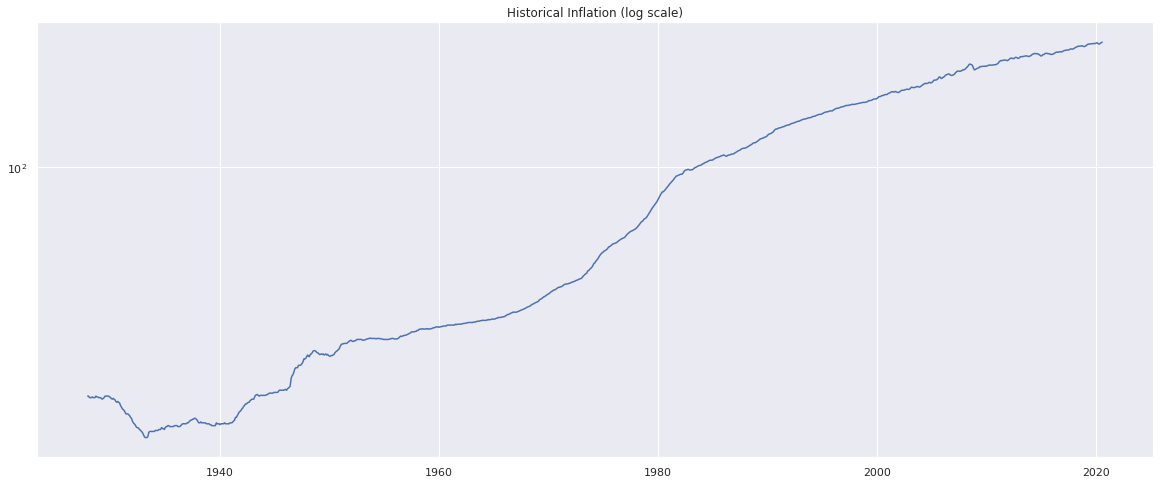

In [20]:
plt.figure(figsize=(20,8))
plt.yscale("log")
plt.title('Historical Inflation (log scale)')
plt.plot(sp_data.set_index('DATE')['CPIAUCNS']);

In [21]:
inf_data_s = inf_data.set_index('DATE')['CPIAUCNS']

inf_data_years = (inf_data_s.index[-1] - inf_data_s.index[0])/np.timedelta64(1, 'Y')
inf_data_total_growth = inf_data_s.iloc[-1]/inf_data_s.iloc[0]
inf_data_growth_rate = ((inf_data_s.iloc[-1]/inf_data_s.iloc[0])**(1/inf_data_years)-1)*100
inf_data_years_to_double = math.log(2)/math.log(1 + inf_data_growth_rate/100)

md('Total growth: {:.2f} times original value  \n' \
   'Yearly growth rate: {:.2f}%  \n' \
   'Doubles every: {:.2f} years  \n'.format(inf_data_total_growth, inf_data_growth_rate, inf_data_years_to_double))

Total growth: 26.52 times original value  
Yearly growth rate: 3.09%  
Doubles every: 22.75 years  


In [22]:
inf_data_foy = inf_data.groupby(inf_data['DATE'].dt.year).first()
inf_data_foy['next_year'] = inf_data_foy['CPIAUCNS'].shift(-1)
inf_rate = ((inf_data_foy['next_year'] / inf_data_foy['CPIAUCNS'] - 1) * 100).dropna()

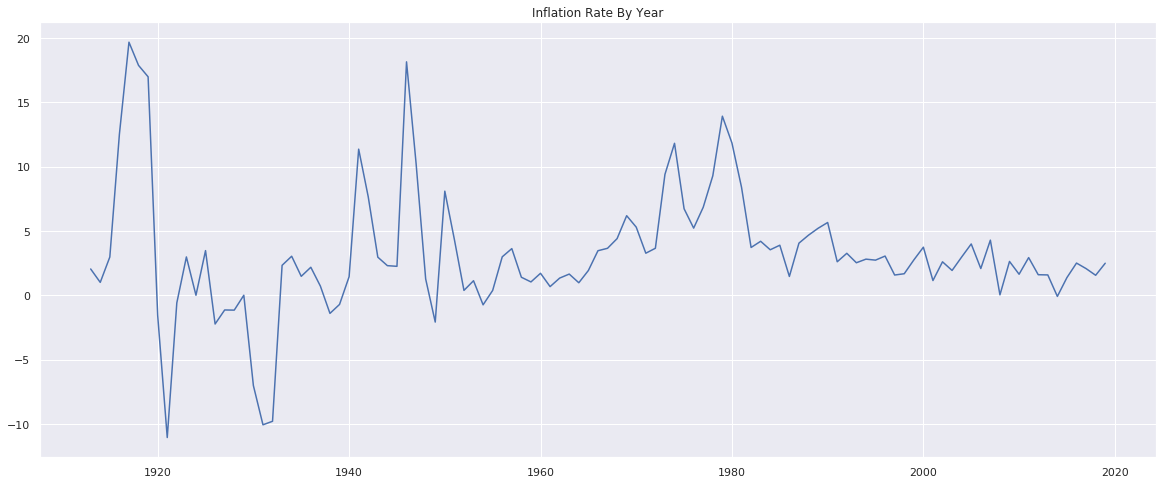

In [23]:
plt.figure(figsize=(20,8))
plt.title('Inflation Rate By Year')
plt.plot(inf_rate);

In [24]:
md('Average yearly inflation rate: {:.2f}%'.format(inf_rate.mean()))

Average yearly inflation rate: 3.22%

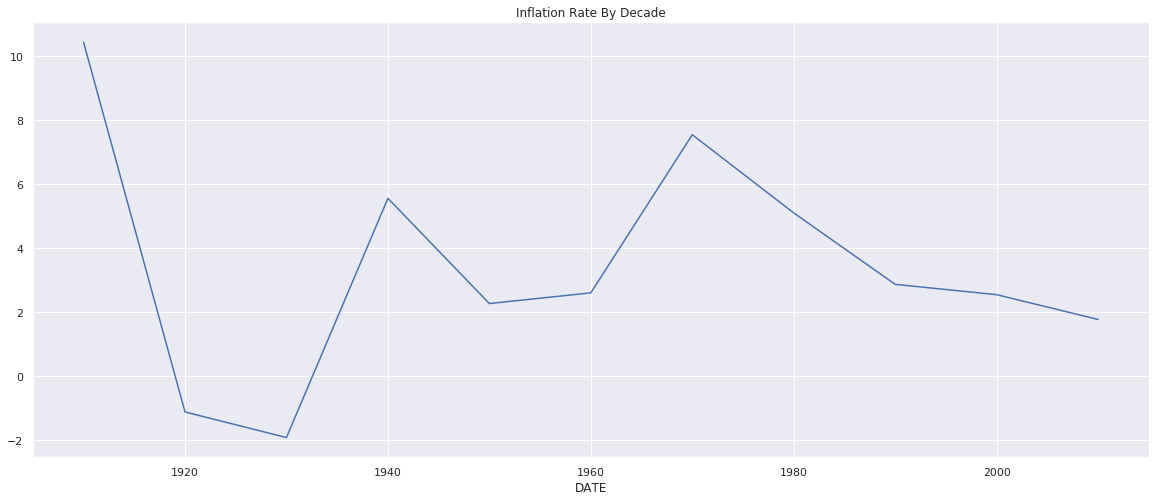

In [25]:
plt.figure(figsize=(20,8))
plt.title('Inflation Rate By Decade')
inf_rate.groupby((inf_rate.index//10)*10).mean().plot();

# S&P 500 Inflation Adjusted

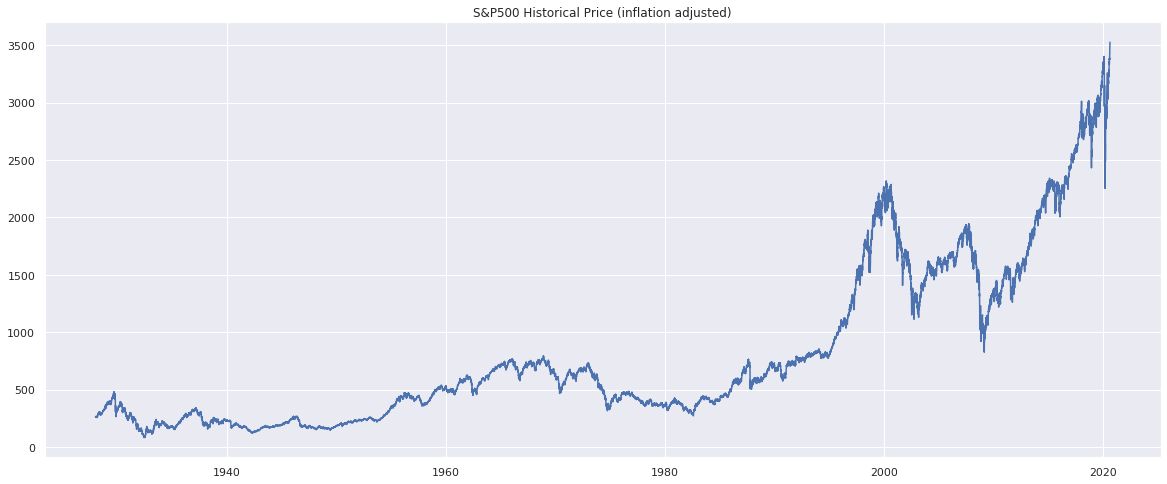

In [26]:
plt.figure(figsize=(20,8))
plt.title('S&P500 Historical Price (inflation adjusted)')
plt.plot(inf_adj_close);

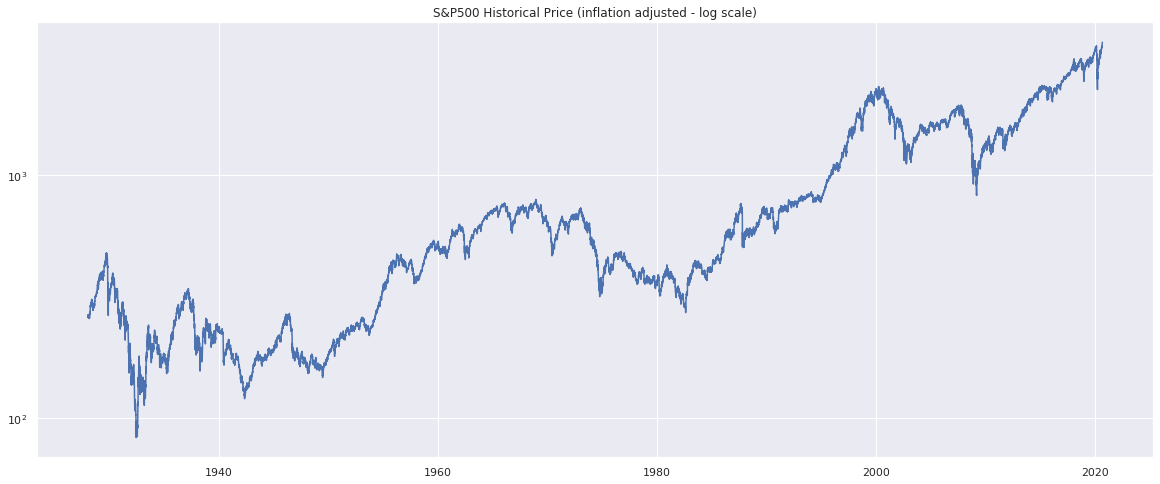

In [27]:
plt.figure(figsize=(20,8))
plt.title('S&P500 Historical Price (inflation adjusted - log scale)')
plt.yscale("log")
plt.plot(inf_adj_close);

In [29]:
inf_total_growth = inf_adj_close.iloc[-1]/inf_adj_close.iloc[0]
inf_rate = ((inf_adj_close.iloc[-1]/inf_adj_close.iloc[0])**(1/years)-1)*100
inf_years_to_double = math.log(2)/math.log(1 + inf_rate/100)
md('Total growth: {:.2f} times original value  \n' \
   'Yearly growth rate: {:.2f}%  \n' \
   'Doubles every: {:.2f} years  \n'.format(inf_total_growth, inf_rate, inf_years_to_double))

Total growth: 13.29 times original value  
Yearly growth rate: 2.83%  
Doubles every: 24.85 years  


In [30]:
inf_adj_year = pd.DataFrame()
inf_adj_year['first'] = inf_adj_close.groupby(inf_adj_close.index.year).first()
inf_adj_year['last'] = inf_adj_close.groupby(inf_adj_close.index.year).last()

In [31]:
inf_adj_year['percent_change'] = (inf_adj_year['last']/inf_adj_year['first'] - 1) * 100

## Percent Change Yearly - Inflation Adjusted 

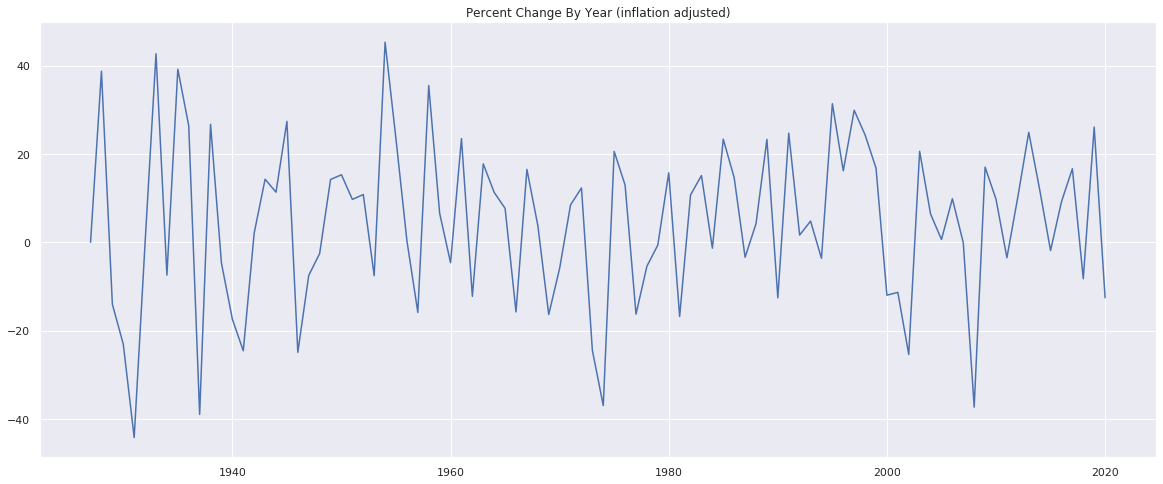

In [105]:
plt.figure(figsize=(20,8))
plt.title('Percent Change By Year (inflation adjusted)')
plt.plot(inf_adj_year['percent_change']);

## Average Return

In [33]:
inf_adj_year['percent_change'].mean()

4.703965122949979

## Average Return - Last 50 Years

In [39]:
inf_adj_year['percent_change'].tail(50).mean()

5.200908075342701

## Average Return - Last 30 Years

In [36]:
inf_adj_year['percent_change'].tail(30).mean()

7.226857371269904

## Average Return - Last 17 Years

In [35]:
inf_adj_year['percent_change'].tail(17).mean()

5.820991408713858

## Average Return - Last 10 Years

In [37]:
inf_adj_year['percent_change'].tail(10).mean()

9.277604941021295

## Average Return - Last 5 Years

In [38]:
inf_adj_year['percent_change'].tail(5).mean()

10.213089834898362